# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**



*   A01363436 José María Blancas Ortiz
*   A01795897 Esteban Sebastián Guerra Espinoza
*   A01795961 Jossie Paola Jiménez Rivera
*   A01795702 Paúl Andrés Yungán Pinduisaca




In [ ]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import os
#from google.colab import userdata, drive
from openai import OpenAI
import openai
import pandas as pd
import numpy as np
import re

import nltk
from nltk.stem import RegexpStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from collections import Counter

import pickle
from tqdm import tqdm
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [ ]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********
#open drive
#drive.mount('/content/drive', force_remount=True)

#Cambiar ruta de los archivos
#cwd = "/content/drive/MyDrive/Colab Notebooks/MNA/NaturalLanguageProcessing/Modulo 2/"
cwd=""
dfa = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfy = pd.read_csv('yelp_labelled.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

data = []
with open('imdb_labelled.txt', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if len(line) > 1:
            # Último carácter como etiqueta
            label = line[-1]
            # Resto de la línea como texto
            text = line[:-1].strip()
            data.append([text, int(label)])  # Convierte label a entero si es un número

# Convertir a DataFrame
dfi = pd.DataFrame(data, columns=['review', 'label'])

df = pd.concat([dfa, dfi, dfy], ignore_index=True)
# *********** Aquí termina la sección de agregar código *************


In [ ]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
# Y veamos sus primeros registros:

df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [ ]:
nltk.download('stopwords')

def generate_stopwords():
  mystopwords = stopwords.words('english')
  negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

  for word in negwords:
      if word in mystopwords:
          mystopwords.remove(word)

  return mystopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sguerra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

def clean(doc):
  #Convierte a minusculas
  tokens = doc.lower()

  #Cambia guiones, puntos,  por espacios
  tokens = re.sub(r'\W', ' ', tokens).strip() #Cambia caracteres no alfabéticos por espacios

  #Sólo caracteres alfabéticos
  tokens = re.sub(r'[^a-zA-Z\s]', '', tokens) #Elimina signos de puntuacion y caracteres especiales

  #Sólo palabras de más de una letra
  tokens = re.findall(r'\b\w{2,}\b', tokens) #Busca palabras de al menos 2 caracteres

  tokens = [re.sub(r"[^\w\s]{2,}", "", s) for s in tokens] #Elimina caracteres repetidos más de dos veces

  #Elimina stopwords
  mystopwords = generate_stopwords()
  tokens = [word for word in tokens if word not in mystopwords]

  rs = RegexpStemmer(r'ing$|ed$|s$', min=3)   # elimina el verbo ing, ed, de palabras de más de 3 caracteres
  tokens = [rs.stem(w) for w in tokens]

  return tokens


# *********** Aquí termina la sección de agregar código *************

In [ ]:
Xclean = [clean(x) for x in df.review]

In [ ]:
for x in df.review[0:5]:
  print(x)

So there is no way for me to plug it in here in the US unless I go by a converter.
Good case, Excellent value.
Great for the jawbone.
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
The mic is great.


In [ ]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

for x in Xclean[0:5]:
  print(x)


['no', 'way', 'plug', 'us', 'unles', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['ti', 'charger', 'conversation', 'last', 'minute', 'major', 'problem']
['mic', 'great']


# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [ ]:

# ************* Inicia la sección de agregar código:*****************************



x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, df.label, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)


# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta - 4:**



Construye tu vocabulario a continuación


In [ ]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


midiccionario = Counter()

for k in range(len(x_train)):
  midiccionario.update(x_train[k])

print('Longitud del diccionario:', len(midiccionario))
print('\nPalabras mas comunes (word,frequency):')
print(midiccionario.most_common(10))
print('\nPalabras menos comunes (word,frequency):')
print(midiccionario.most_common()[::-1])  # Lista al reves

min_freq = 3

midicc = {w: count for w, count in midiccionario.items() if count > min_freq}

# *********** Aquí termina la sección de agregar código *************

Longitud del diccionario: 3469

Palabras mas comunes (word,frequency):
[('not', 219), ('good', 164), ('movie', 140), ('great', 138), ('phone', 134), ('film', 130), ('work', 113), ('time', 101), ('one', 100), ('like', 89)]

Palabras menos comunes (word,frequency):
[('resound', 1), ('evaluate', 1), ('decision', 1), ('za', 1), ('ericson', 1), ('disapoinment', 1), ('disturb', 1), ('blame', 1), ('hostes', 1), ('ignor', 1), ('supris', 1), ('pleasantly', 1), ('hey', 1), ('constant', 1), ('marr', 1), ('savant', 1), ('ohhh', 1), ('velvet', 1), ('waylaid', 1), ('pyromaniac', 1), ('godfather', 1), ('heaven', 1), ('manna', 1), ('sibl', 1), ('smashburger', 1), ('imagine', 1), ('google', 1), ('tooth', 1), ('bothersome', 1), ('aurvg', 1), ('fausa', 1), ('trond', 1), ('forgot', 1), ('charismatic', 1), ('lie', 1), ('nonetheles', 1), ('lazy', 1), ('pearl', 1), ('roth', 1), ('significantly', 1), ('brows', 1), ('web', 1), ('snug', 1), ('gel', 1), ('additional', 1), ('musician', 1), ('biographical', 1), ('

In [ ]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:')


# ******* Inicia la sección de agregar código: ***********


print(len(midicc))


# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado:
693


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Porque el objetivo es evitar que el modelo tenga acceso anticipado a datos de validación o prueba (**data leakage**).  
Si se genera el vocabulario usando todo el dataset, el modelo estaría expuesto a palabras exclusivas de validación o prueba, contaminando así la evaluación y generando métricas artificialmente altas.  
Esto rompe la independencia entre el entrenamiento y la evaluación, produciendo un sesgo positivo que da una falsa sensación de rendimiento.  
Por tanto, el vocabulario debe formarse únicamente con el set de entrenamiento, asegurando que cualquier palabra nueva en validación o prueba sea tratada como desconocida (**OOV - Out Of Vocabulary**), reflejando así el comportamiento real del modelo en datos no vistos.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [ ]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])


# *********** Aquí termina la sección de agregar código *************


In [ ]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

['star', 'don', 'much', 'better', 'people', 'like', 'wast']
['special', 'suck']
['not', 'tip', 'felt', 'server', 'terrible', 'job']
['call', 'cook', 'steak', 'don', 'understand']
['however', 'sometime', 'wrong', 'button']


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

| Modelo                    | Tamaño / Dimensiones | Precisión | Velocidad | Uso recomendado                                          |
|---------------------------|----------------------|-----------|-----------|-----------------------------------------------------------|
| `text-embedding-3-small`  | 1536                 | Alta (mejor que Ada-002) | Muy rápida  | Casos donde se requiere alta eficiencia y rapidez, con buen rendimiento para tareas generales. Ideal para producción con limitaciones de recursos. |
| `text-embedding-3-large`  | 3072                 | Muy alta  | Más lenta  | Casos donde se busca máxima precisión semántica, aplicaciones críticas como motores de búsqueda avanzados, recuperación de información, clasificación compleja. |
| `text-embedding-ada-002`  | 1536                 | Buena (inferior a 3-small y 3-large) | Rápida  | Casos generales, prototipos, aplicaciones no críticas. Fue el estándar hasta la llegada de la serie `text-embedding-3`. |




- **`text-embedding-3-small`** ofrece una mejora significativa en rendimiento respecto a `ada-002`, con un costo cinco veces menor.
- **`text-embedding-3-large`** proporciona la mejor precisión, especialmente en tareas multilingües, aunque con un mayor costo computacional.
- Ambos modelos de la serie 3 permiten ajustar la dimensionalidad de las incrustaciones mediante el parámetro `dimensions`, lo que ofrece flexibilidad entre rendimiento y costo.




**Referencias:**
- OpenAI: [Nuevos modelos de incrustaciones y actualizaciones de API](https://openai.com/index/new-embedding-models-and-api-updates/)
- OpenAI: [Guía de incrustaciones](https://platform.openai.com/docs/guides/embeddings)

### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [ ]:
raise RuntimeError("🚫 La siguiente celda está bloqueada, no correr a menos que se cambien los embeddings.")

RuntimeError: 🚫 La siguiente celda está bloqueada, no correr a menos que se cambien los embeddings.

In [ ]:

# Inicializa la API
client = OpenAI(api_key=api_key)
model_id = "text-embedding-3-small"  # o text-embedding-3-large

# Tu vocabulario
vocabulario = list(midicc.keys())

# Diccionario para guardar los embeddings
embedding_dict = {}

# Función para obtener el embedding de una palabra
def get_embedding(text):
    response = client.embeddings.create(
        model=model_id,
        input=text
    )
    return response.data[0].embedding

# Generar embeddings
for palabra in tqdm(vocabulario, desc="Generando embeddings"):
    try:
        embedding_dict[palabra] = get_embedding(palabra)
        #time.sleep(5)
    except Exception as e:
        print(f"❌ Error con la palabra '{palabra}': {e}")

# Guardar el diccionario en archivo .pkl
with open("embeddings_vocab.pkl", "wb") as f:
    pickle.dump(embedding_dict, f)

print("✅ Diccionario de embeddings guardado como 'embeddings_vocab.pkl'")


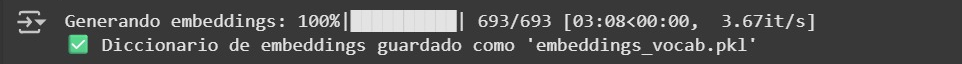

In [ ]:
# Read from pickle
file_name = 'embeddings_vocab.pkl'

with open(file_name, 'rb') as f:
    embeddings_vocab = pickle.load(f)

print(type(embeddings_vocab))
print(len(embeddings_vocab))
print(list(embeddings_vocab.items())[:5])  # View first 5 items

<class 'dict'>
693
[('star', [-0.013770227320492268, -0.012703923508524895, -0.020466158166527748, -0.02024831250309944, -0.013804624788463116, -0.01239435188472271, -0.007263479754328728, -0.003935579210519791, 0.022036951035261154, 0.001886097015812993, -0.00830112025141716, 0.005649691913276911, -0.029741857200860977, -0.057328175753355026, -0.03425931930541992, 0.04700910300016403, -0.04375286400318146, -0.032012052834033966, 0.017301643267273903, 0.02308032289147377, 0.02767804265022278, 0.0231376513838768, 0.012497542425990105, 0.03192032873630524, -0.0019477247260510921, 0.03556640073657036, 0.012199435383081436, -0.005182466935366392, 0.01992727443575859, -0.02337842993438244, -0.0004016555321868509, -0.03102600947022438, 0.06902312487363815, -0.02366507053375244, 0.010754765942692757, 0.03918953984975815, 0.03476380556821823, -0.012990565039217472, -0.013242808170616627, -0.0005188200157135725, -0.02760924957692623, 0.031805671751499176, 0.05320054665207863, 0.0329980961978435

Input tokens
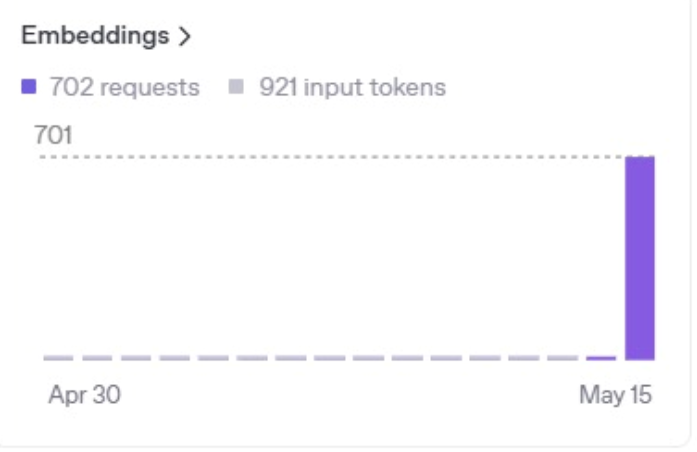


# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [ ]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

def get_embedding_vector(dataset, labels, embeddings_vocab):
    vector_promedio = []

    # Por cada comentario
    for document in dataset:
        vectores = []
        for key, vec in embeddings_vocab.items():  # Verificar los tokens que pertenecen
            if key in document:
                vectores.append(vec)

        if len(vectores) == 0:  # Frase vacía
            vectores.append(np.zeros_like(next(iter(embeddings_vocab.values()))))  # Vector de ceros del mismo tamaño

        # Calcular el promedio
        vector_promedio.append(np.mean(vectores, axis=0))

    # Convertimos a array 2D
    vector_promedio = np.array(vector_promedio)

    # Convertimos las etiquetas a columna
    labels_col = np.array(labels).reshape(-1, 1)

    return np.concatenate((vector_promedio, labels_col), axis=1)


trainEmb = get_embedding_vector(train_x, y_train, embeddings_vocab)
valEmb = get_embedding_vector(val_x, y_val, embeddings_vocab)
testEmb = get_embedding_vector(test_x, y_test, embeddings_vocab)

# *********** Aquí termina la sección de agregar código *************

In [ ]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 1537)
Val-Emb: (450, 1537)
Test-Emb: (450, 1537)


In [ ]:
#Última columna = label
trainEmb[4:9]

array([[-0.0176735 , -0.01266239, -0.00622153, ..., -0.00619097,
        -0.0098967 ,  0.        ],
       [-0.00295585, -0.01146695, -0.01098261, ..., -0.00299255,
        -0.01104914,  1.        ],
       [-0.00194193, -0.00125237,  0.00376287, ..., -0.00382101,
         0.00253444,  1.        ],
       [ 0.00555654,  0.00850322, -0.03107183, ...,  0.02308902,
        -0.006193  ,  1.        ],
       [-0.00491573, -0.01317422,  0.00849377, ..., -0.01050381,
        -0.00646055,  0.        ]])

# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [ ]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


modeloLRcount = LogisticRegression(penalty='elasticnet', tol=0.0001, C=0.6, l1_ratio = 0.75,
                                   random_state=None, solver='saga', max_iter=10000)

modeloLRcount.fit(trainEmb[:, :-1], trainEmb[:,-1])

print('LR: Train-accuracy: %.2f%%' % (100*modeloLRcount.score(trainEmb[:, :-1], trainEmb[:,-1])))
print('LR: Val-accuracy: %2.f%%' % (100*modeloLRcount.score(valEmb[:, :-1], valEmb[:,-1])))

y_predLR = modeloLRcount.predict(testEmb[:, :-1])
print(classification_report(testEmb[:,-1], y_predLR))

# *********** Aquí termina la sección de agregar código *************


LR: Train-accuracy: 79.43%
LR: Val-accuracy: 79%
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       216
         1.0       0.85      0.74      0.79       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



In [ ]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


modeloRFcount = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=5000, min_samples_split=50,
                                       min_samples_leaf=3, max_features='sqrt', n_jobs=7)

modeloRFcount.fit(trainEmb[:, :-1], trainEmb[:,-1])

print('LR: Train-accuracy: %.2f%%' % (100*modeloRFcount.score(trainEmb[:, :-1], trainEmb[:,-1])))
print('LR: Val-accuracy: %2.f%%' % (100*modeloRFcount.score(valEmb[:, :-1], valEmb[:,-1])))

y_predRF = modeloRFcount.predict(testEmb[:, :-1])
print(classification_report(testEmb[:,-1], y_predRF))

# *********** Aquí termina la sección de agregar código *************

LR: Train-accuracy: 95.67%
LR: Val-accuracy: 82%
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       216
         1.0       0.83      0.76      0.79       234

    accuracy                           0.79       450
   macro avg       0.80      0.79      0.79       450
weighted avg       0.80      0.79      0.79       450



# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


In [ ]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


mejormodelo = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=5000, min_samples_split=50,
                                       min_samples_leaf=3, max_features='sqrt', n_jobs=7)

mejormodelo.fit(trainEmb[:, :-1], trainEmb[:,-1])

print('RF: Test-accuracy: %.2f%%' % (100*mejormodelo.score(testEmb[:, :-1], testEmb[:,-1])))

y_predRF = mejormodelo.predict(testEmb[:, :-1])
print(classification_report(testEmb[:,-1], y_predRF))


# *********** Aquí termina la sección de agregar código *************

RF: Test-accuracy: 80.00%
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       216
         1.0       0.84      0.76      0.80       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



# **Pregunta - 10:**

In [ ]:
raise RuntimeError("🚫 La siguiente celda está bloqueada, no correr a menos que se cambien los embeddings.")

In [ ]:
# Incluye todas las líneas de código y celdas que consideres adecuadas para este ejercicio.

model_id = "text-embedding-3-small"

def get_embedding(text):
    # Si el texto está vacío o solo tiene espacios, devolver vector de ceros
    if not isinstance(text, str) or text.strip() == "":
        return [0.0] * 1536

    response = client.embeddings.create(
        model=model_id,
        input=text.strip()
    )
    return response.data[0].embedding

embeddings = []
etiquetas = []

for _, row in tqdm(df.iterrows(), desc="Generando embeddings"):
    texto = row['review']
    etiqueta = row['label']

    try:
        emb = get_embedding(texto)
        embeddings.append(emb)
        etiquetas.append(etiqueta)
    except Exception as e:
        print(f"Error con el comentario: {texto} - {e}")


matriz = np.vstack(embeddings)

# Guardar en .pkl
with open("embeddings_com.pkl", "wb") as f:
    pickle.dump(matriz, f)

# Guardar en archivo .pkl
with open("etiquetas_com.pkl", "wb") as f:
    pickle.dump(etiquetas, f)


Generando embeddings: 3000it [26:15,  1.90it/s]


In [ ]:
# Read from pickle
file_name = 'embeddings_com.pkl'

with open(file_name, 'rb') as f:
    embeddings_com = pickle.load(f)

print(type(embeddings_com))
print(len(embeddings_com))
print(embeddings_com.shape)

print('################################# Etiquetas')

file_name = 'etiquetas_com.pkl'

with open(file_name, 'rb') as f:
    etiquetas_com = pickle.load(f)

print(type(etiquetas_com))
print(len(etiquetas_com))

<class 'numpy.ndarray'>
3000
(3000, 1536)
################################# Etiquetas
<class 'list'>
3000


In [ ]:
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(embeddings_com, etiquetas_com, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


In [ ]:
#################################################LR MODEL

modeloLR = LogisticRegression(penalty='elasticnet', tol=0.0001, C=0.6, l1_ratio = 0.75,
                                   random_state=None, solver='saga', max_iter=10000)

modeloLR.fit(x_train, y_train)

print('LR: Train-accuracy: %.2f%%' % (100*modeloLR.score(x_train, y_train)))
print('LR: Val-accuracy: %2.f%%' % (100*modeloLR.score(x_val, y_val)))
print('LR: Test-accuracy: %2.f%%' % (100*modeloLR.score(x_test, y_test)))

y_predLR = modeloLR.predict(x_test)
print(classification_report(y_test, y_predLR))

print('#####################################################################')

#################################################RF MODEL

modeloRF = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=5000, min_samples_split=50,
                                       min_samples_leaf=3, max_features='sqrt', n_jobs=7)

modeloRF.fit(x_train, y_train)

print('RF: Train-accuracy: %.2f%%' % (100*modeloRF.score(x_train, y_train)))
print('RF: Val-accuracy: %2.f%%' % (100*modeloRF.score(x_val, y_val)))
print('RF: Test-accuracy: %2.f%%' % (100*modeloRF.score(x_test, y_test)))

y_predRF = modeloRF.predict(x_test)
print(classification_report(y_test, y_predRF))


LR: Train-accuracy: 97.86%
LR: Val-accuracy: 97%
LR: Test-accuracy: 98%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       216
           1       0.98      0.98      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

#####################################################################
RF: Train-accuracy: 99.24%
RF: Val-accuracy: 96%
RF: Test-accuracy: 98%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       216
           1       0.98      0.98      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [ ]:
mejormodelo1 = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=5000, min_samples_split=50,
                                       min_samples_leaf=3, max_features='sqrt', n_jobs=7)

mejormodelo1.fit(x_train, y_train)

print('RF: Test-accuracy: %2.f%%' % (100*mejormodelo1.score(x_test, y_test)))

y_predRF = mejormodelo1.predict(x_test)
print(classification_report(y_test, y_predRF))

RF: Test-accuracy: 98%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       216
           1       0.99      0.97      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Como parte de la actividad y que se nos dio la facilidad de utilizar otras opciones, como Hugging face, incluimos el código para comparar qué método es el mejor y generar un análisis mucho más robusto.

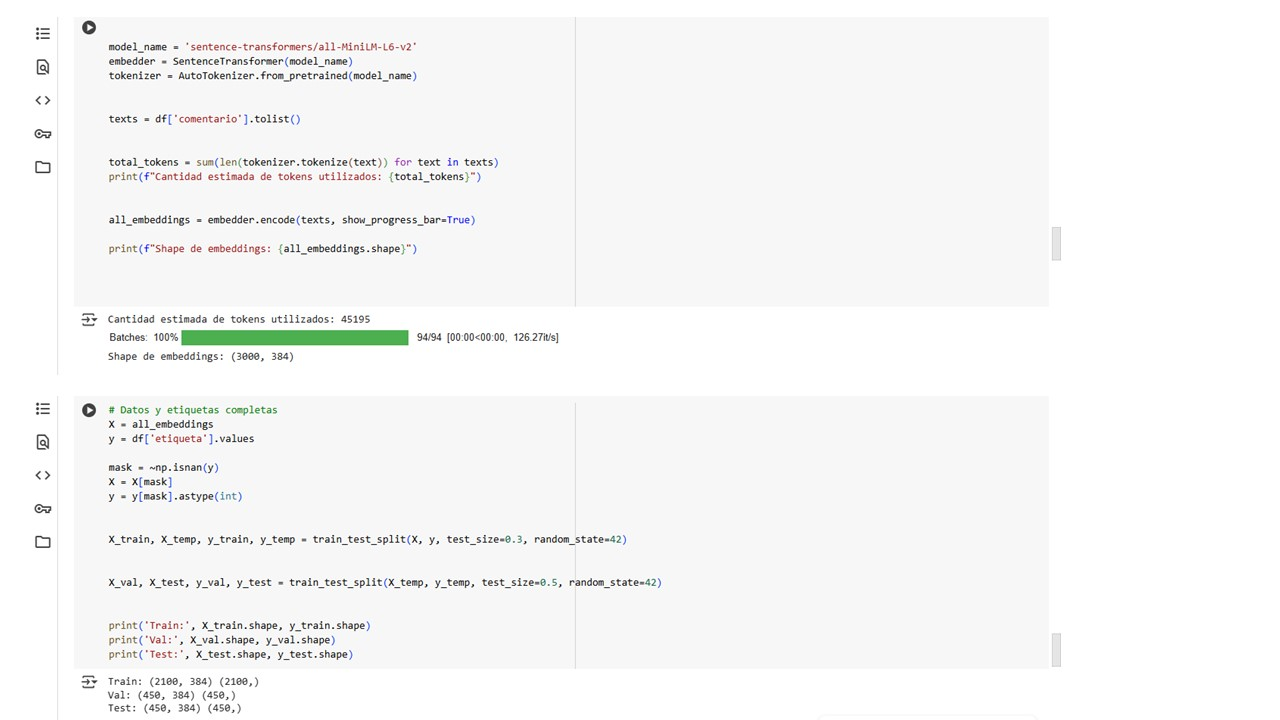

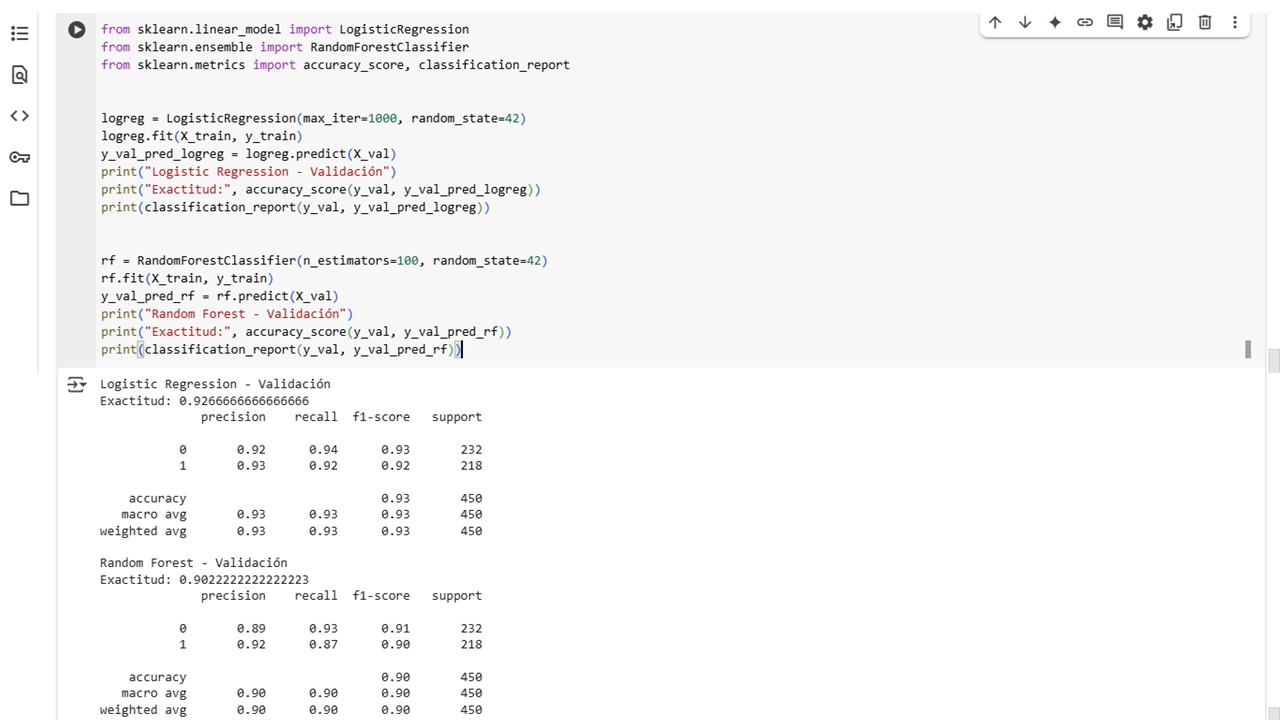

Como se puede apreciar, se utilizaron entradas y tratamiento de la información similares con el fin de hacer la comparación lo más exacta posible. Dicho esto, podemos concluir que el utilizar herramientas con API KEY como Open AI sí muestran un rendimiento ligeramente superior. Si bien, Hugging face demostró altos porcentajes, no logró el nivel de planchado de datos que hubiéramos querido, sin embargo, resultó ser mucho más sencillo de procesar, e incluso, de manejar a la hora de trabajar con embeddings.

# **Pregunta - 11:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

El objetivo de esta actividad fue comprender y aplicar cómo los modelos de embeddings avanzados, en particular los proporcionados por OpenAI, permiten transformar datos textuales en representaciones vectoriales robustas, optimizando tareas de clasificación supervisada. A través del desarrollo del pipeline completo, se profundizó en la importancia de cada etapa previa al modelado: preprocesamiento, construcción de vocabulario evitando data leakage, y generación de embeddings eficientes.

La implementación práctica reforzó la comprensión de que las representaciones semánticas de calidad, cuando se integran con algoritmos supervisados adecuados como Random Forest, ofrecen resultados significativamente superiores a métodos tradicionales de representación de texto, permitiendo modelos más precisos, estables y generalizables.

Más allá del desempeño observado, la actividad permitió reflexionar sobre la relevancia de diseñar flujos de procesamiento de NLP que respeten las mejores prácticas y la importancia de evaluar no solo métricas, sino también la calidad y utilidad de las representaciones obtenidas, preparando al estudiante para enfrentar escenarios reales de procesamiento de lenguaje en contextos productivos.

Incluso, al haber hecho más de un modelo e implementar Hugging Face como alternativa dada el tiempo extra que se nos dio para la actividad, podemos observar que prácticamente la lógica detrás de cada herramienta es sumamente similar, solo que responden a objetivos distintos.

En temas de precisión y exactitud demuestran diferencias notorias, pero ambos están en niveles aceptables, y Hugging face fue mucho más fácil de implementar, lo que nos lleva a evaluar de igual manera a qué le debemos dar prioridad en cada objetivo de análisis y modelos que ataquemos.

Evaluar las salidas también permite conocer qué es lo que está pasando detrás del procesamiento, por lo cual, puedes generar modelos mucho más finos y detallados, generando limpiezas extra, nuevos diccionarios o nuevas exclusiones que no solo te lleven a una precisión adecuada, sino a un entendimiento real de lo que, en este caso, los comentarios y palabras quieren decir.


### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**